In [1]:
#default_exp core.random_variable

- [ ] TODO: implement kde estimation and entropy estimation
- [ ] TODO: make an abstracction for random varriable in order to bring sklearn GMM and kde to same abstractions of sample, etc...
- [ ] TODO: make RVArray an instance of np.array
- [ ] TODO: make RVarray access attributes for multidimensional RVarrays and return array with same size of result objects

In [437]:
#hide
from nbdev.showdoc import *

In [ ]:
#TODO: Include GMM from skleaern for multimodal normal

# Meta Distributions

> Extension of SciPy rv_continuous Class, containing some useful methods for Maximum Likelihood Estimation and other distribution methods.

## Helper Functions

In [1]:
#export
from sklearn.preprocessing import QuantileTransformer
import scipy.stats as stats
import numpy as np
import tqdm


def ctqdm(iterable, verbose = False, notebook = False,**tqdm_kwargs):
    '''
    progress bar handler (custom tqdm)
    '''
    if not verbose:
        return iterable
    else:
        if notebook:
            return tqdm.notebook(iterable,**tqdm_kwargs)
        else:
            return tqdm.tqdm(iterable,**tqdm_kwargs)




## RandomVariable Class - 

In [47]:
        
class RandomVariable():
    '''
    A container for distribution objects
    '''
    
    @classmethod
    def from_weights(cls, values, weights, n_samples = 100, **ecdf_kwargs):
        data = np.random.choice(values,size = n_samples, p = weights)
        return cls.__init__(data, **ecdf_kwargs)
    
    def __init__(self, data, verbose = False, **ecdf_kwargs):        
        self.samples = data
        self._fitted_dists = {}
        self.log_likelihood = []
        self.verbose = False
        self.ecdf = QuantileTransformer(**ecdf_kwargs).fit(data)
        return
        
    def __getitem__(self, item):
        if item == 'best':
            try:
                item = self._best_fit_alias
            except AttributeError:
                raise AttributeError('RandomVariable object has no "best" fit yet. Fit at least one density function through fit_dist method')
        
        return self._fitted_dists[item][0]
    
    #def __repr__(self):
    #    return f'RandomVariable({str(self.samples)})'
    
    def fit_best(self, candidates = ['norm','halfnorm','lognorm']):
        #fit all and make alias for best fit
        self._fit_all(self.samples, candidates)
        self._check_best()
        return self
    
    
    def fit_dist(self, dist):
        return self._fit_dist(self.samples,dist)
    
    def _check_best(self):
        dists_aliases = list(self._fitted_dists)
        dists_arr = np.array([i[1] for i in self._fitted_dists.values()])
        best_fit_idx = np.argmax(dists_arr)
        self._best_fit_alias = dists_aliases[best_fit_idx]
        return
    
    def _fit_all(self, data, candidates):        
        #TODO: check for multiplicity in candidates aliases
        for candidate in ctqdm(candidates, verbose = self.verbose):
            self.fit_dist(candidate)            
        return self

    
    def _fit_dist(self, data, dist):      
        '''
        fits a specified distribution through scipy.stats.rv_continuous.fit method
        '''
        alias, dist_name = self._handle_dist_names(dist)
        alias, dist_class = self._get_dist_from_name(alias, dist_name)
        if alias.lower() == 'best':
            raise ValueError('"best" cannot be an alias for a distribution. its internally assgined to the best fit dist')
        params = dist_class.fit(data)
        log_likelihood = self._get_log_likelihood(data, dist_class, params)
        self._fitted_dists = {**self._fitted_dists, **{alias:(dist_class(*params),log_likelihood)}}
        self.log_likelihood = list({**dict(self.log_likelihood), **{alias:log_likelihood}}.items())
        return self
    
    def _get_log_likelihood(self, data, dist, params):        
        return np.log(np.product(dist.pdf(data,*params)))
    
    def _get_dist_from_name(self, alias, dist_name):
        '''
        handles dist_names. if str tries to get an attribute from scipy.stats accordingly
        that is also instance of scipy.stats.rv_continuous
        '''
        if isinstance(dist_name,str):        
            if isinstance(getattr(stats,dist_name), stats.rv_continuous):
                alias = dist_name
                return (alias, getattr(stats,dist_name))
            else:
                raise ValueError(f'dist must be a valid scipy.stats.rv_continuous instance, not {getattr(stats,dist_name)}')

        elif isinstance(dist_name, stats.rv_continuous):
            return (alias, dist_name)
        else:
            raise ValueError(f'dist must be a valid scipy.stats.rv_continuous instance or str, not {dist_name}')
    
    def _handle_dist_names(self, candidate_value):
        '''
        checks the inputs in elements of "candidates"
        returns a named tuple
        '''
        if isinstance(candidate_value, str):
            return candidate_value, candidate_value

        elif isinstance(candidate_value, tuple):

            if not len(candidate_value) == 2:
                raise ValueError(f'candidate named tuple must be of size 2, "{candidate_value}" has size {len(candidate_value)}')

            if not isinstance(candidate_value[0], str):
                raise ValueError(f'a candidate must be a str or named tuple (alias[str],<rv_continuous intance>), alias is of type {candidate_value[0].__class__}')

            else:
                return candidate_value
    
    def sample(self, size, dist = 'empirical', **kwargs):
        
        if dist == 'empirical':
            sampled_idxs = np.random.choice([*range(self.samples.shape[0])], size = size, **kwargs)
            return self.samples[sampled_idxs]
        else:
            return self[dist].rvs(size = size, **kwargs)
    
    def cdf(self, data, dist = 'empirical'):
        if dist == 'empirical':
            return self.ecdf.transform(data)
        else:
            return self[dist].cdf(data)
    
    def pdf(self, data, dist = 'best'):
        return self[dist].pdf(data)
    
    def ppf(self, data, dist = 'empirical'):
        if dist == 'empirical':
            return self.ecdf.inverse_transform(data)
        else:
            return self[dist].ppf(data)
            
        

A RandomVariable Class facilitates the process of fitting multiple parametric distributions avalible in https://docs.scipy.org/doc/scipy/reference/stats.html from a data sample, for example:

Dist args:
(2, 0, 1)
[('norm', -26.93720539377202), ('halfnorm', -19.524428805168604), ('lognorm', -19.480501239365616)]
MLE fitted dist args:
(0.5838891807958072, -0.13527731012023725, 0.7932959807999199)


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2370: UserWarning: n_quantiles (1000) is greater than the total number of samples (30). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


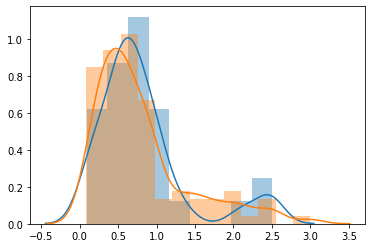

In [48]:
import seaborn as sns
dist_args = (2,0,1)

#data = stats.lognorm.rvs(dist_args[0], loc = dist_args[1], scale = dist_args[2], size = 30)
data = stats.halfnorm.rvs(loc = dist_args[1], scale = dist_args[2], size = [30,1])
rv = RandomVariable(data)
rv.fit_best(candidates = ['norm','halfnorm','lognorm'])

mle_samples = rv['best'].rvs([100,1])
#plot distributions

print('Dist args:')
print(dist_args)
print(rv.log_likelihood)
print('MLE fitted dist args:')
print(rv['best'].args)

sns.distplot(data)
sns.distplot(mle_samples)


## RVArray - 

In [49]:
#check for np.vectorize for vectorized methods
from functools import partial

class RVArray():
    '''
    An array that contains RandomVariable objects and facilitates method calls and getting attributes
    '''
    def __init__(self, data):
        ''' the constructor recieves a list of RandomVariable items'''
        self.data = np.array(data)
    
    def __getattr__(self, attr):
        attr_list = [getattr(i,attr) for i in self.data]                
        return RVArray(attr_list)      
    
    def __call__(self, *args, **kwargs):
        results = [i(*args,**kwargs) for i in self.data]
        if all([isinstance(i,np.ndarray) for i in results]):
            return np.array(results)
        else:
            return RVArray(results)
    
    def __getitem__(self, *args):

        if len(args) > 1:
            return RVArray(self.data[args])
        else:
            if args[0].__class__ == str:
                return RVArray([i[args[0]] for i in self.data])
            else:
                return self.data[args]      
    
    def __repr__(self):
        return f'RVArray({str(self.data)})'

A RVArray is a data sctructure tthat facilitates handling multiple RandomVariable objects, assessing RandomVariable methods and attributes in a vectorwise fashion

In [59]:
rv2 = RandomVariable(mle_samples)
rv_arr = RVArray([rv,rv2])
rv_arr.fit_dist('norm')
rv_arr.sample(size = 10)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2370: UserWarning: n_quantiles (1000) is greater than the total number of samples (100). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


array([[[0.9449261 ],
        [0.45093506],
        [0.64917819],
        [0.09280919],
        [1.33365848],
        [0.51471548],
        [0.9449261 ],
        [0.20778676],
        [1.33365848],
        [0.39920725]],

       [[0.46301309],
        [0.61523009],
        [0.39394393],
        [0.57511211],
        [0.46301309],
        [0.54276802],
        [0.96136981],
        [0.71231938],
        [0.87036494],
        [0.63894518]]])

In [39]:
rv_arr['best'].args.data.flatten()

array([0.02168409, 0.9791109 , 0.02412975, 0.94623213])

In [ ]:
def get_entropy(X):
   if len(X.shape)==1:
       X=X.reshape(-1,1)
   params = {'bandwidth': np.logspace(-10, 10, 20)}
   gs = GridSearchCV(KernelDensity(), params)
   gs.fit(X)
   kde=gs.best_estimator_
   log_probs=kde.score_samples(X)
   return -np.mean(log_probs)